## Imports

In [1]:
import os
import pathlib
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import pyarrow.parquet as pq
import seaborn as sns
import statsmodels.api as sm
import toml
from matplotlib import rcParams

rcParams.update({"figure.autolayout": True})

# create a venn diagram of the features that are significant in all conditions
from matplotlib_venn import venn2, venn3, venn3_unweighted

warnings.filterwarnings("ignore")
from pycytominer.cyto_utils import infer_cp_features
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd

In [2]:
# Parameters
cell_type = "PBMC"
treatment1 = "DMSO_0.100_%_DMSO_0.025_%"
treatment2 = "LPS_0.010_ug_per_ml_DMSO_0.025_%"
treatment3 = "H2O2_100.000_nM_DMSO_0.025_%"

In [3]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = pathlib.Path(f"../data/{cell_type}_preprocessed_sc_norm.parquet")
df = pq.read_table(file_path).to_pandas()
df_metadata = df.filter(regex="Metadata")
df_data = df.drop(df_metadata.columns, axis=1)
cp_features = infer_cp_features(df)

In [4]:
trt1 = df[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].str.contains(f"{treatment1}")
]
trt2 = df[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].str.contains(f"{treatment2}")
]
trt3 = df[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].str.contains(f"{treatment3}")
]

### Set up DF

In [5]:
combined_df = pd.concat([trt1, trt2, trt3], axis=0)
print(len(trt1), len(trt2), len(trt3), len(combined_df))
combined_df.head(3)

215130 143080 120289 478499


,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Nuclei_Texture_SumEntropy_CorrPM_3_01_256,Nuclei_Texture_SumVariance_CorrPM_3_01_256,Nuclei_Texture_Variance_CorrER_3_00_256,Nuclei_Texture_Variance_CorrGasdermin_3_00_256,Metadata_Treatment,Metadata_Dose,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,twob_Metadata_Treatment_Dose_Inhibitor_Dose,threeb_Metadata_Treatment_Dose_Inhibitor_Dose,fourb_Metadata_Treatment_Dose_Inhibitor_Dose
315708,PBMC,B06,25314,6,DMSO,0.025,%,DMSO,0.100,%,...,-0.299580,-0.137086,-0.111979,-0.115607,DMSO,0.100_%,DMSO_0.100_%_DMSO_0.025_%,DMSO_DMSO_0.025__0.100_%,DMSO__0.100_%__%_DMSO_0.025,DMSO__0.100_%__%_DMSO__0.025
315709,PBMC,B06,25314,6,DMSO,0.025,%,DMSO,0.100,%,...,-0.906742,-0.156287,-0.171005,-0.161728,DMSO,0.100_%,DMSO_0.100_%_DMSO_0.025_%,DMSO_DMSO_0.025__0.100_%,DMSO__0.100_%__%_DMSO_0.025,DMSO__0.100_%__%_DMSO__0.025
315710,PBMC,B06,25314,6,DMSO,0.025,%,DMSO,0.100,%,...,-0.392149,-0.146205,-0.169050,-0.166613,DMSO,0.100_%,DMSO_0.100_%_DMSO_0.025_%,DMSO_DMSO_0.025__0.100_%,DMSO__0.100_%__%_DMSO_0.025,DMSO__0.100_%__%_DMSO__0.025


## Anova + Post Hoc testing (tukeyHSD)

In [6]:
# anova for each feature in the dataframe with posthoc tukey test to determine which groups are different from each other
lst = []
for i in cp_features:
    formula = f"{i} ~ C(oneb_Metadata_Treatment_Dose_Inhibitor_Dose) + C(Metadata_number_of_singlecells)"
    model = ols(formula, combined_df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    posthoc = pairwise_tukeyhsd(
        combined_df[i],
        combined_df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
        alpha=0.001,
    )
    # print(posthoc)
    lst.append([posthoc, i])

In [7]:
tukey_df = pd.DataFrame()
for i in lst:
    j = pd.DataFrame(i[0]._results_table.data[1:])
    j["features"] = np.repeat(i[1], len(j))
    tukey_df = pd.concat([tukey_df, j], axis=0)

    np.repeat(i[1], len(j))

tukey_df.columns = [
    "group1",
    "group2",
    "meandiff",
    "lower",
    "upper",
    "p-adj",
    "reject",
    "features",
]
tukey_df.head(3)

,group1,group2,meandiff,lower,upper,p-adj,reject,features
0,DMSO_0.100_%_DMSO_0.025_%,H2O2_100.000_nM_DMSO_0.025_%,-0.0492,-0.0000,-0.0623,-0.0360,True,Cytoplasm_AreaShape_Compactness
1,DMSO_0.100_%_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%,-0.0422,-0.0000,-0.0546,-0.0297,True,Cytoplasm_AreaShape_Compactness
2,H2O2_100.000_nM_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%,0.0070,0.1884,-0.0073,0.0213,False,Cytoplasm_AreaShape_Compactness


In [8]:
# drop the other organelle
# make new column with the absolute value of the p-adj
tukey_df["p-adj_abs"] = abs(tukey_df["p-adj"])
tukey_df_sig = tukey_df[tukey_df["p-adj_abs"] < 0.01]
# make new column that states if the relationship is positive or negative
tukey_df_sig["pos_neg"] = np.where(tukey_df_sig["p-adj"] > 0, "positive", "negative")
# order the features by p-adj value
tukey_df_sig.head(2)

,group1,group2,meandiff,lower,upper,p-adj,reject,features,p-adj_abs,pos_neg
0,DMSO_0.100_%_DMSO_0.025_%,H2O2_100.000_nM_DMSO_0.025_%,-0.0071,0.1201,-0.0200,0.0058,False,Cytoplasm_AreaShape_Orientation,0.0058,positive
1,DMSO_0.100_%_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%,-0.0059,0.1907,-0.0182,0.0063,False,Cytoplasm_AreaShape_Orientation,0.0063,positive


## Venn Diagrams

#### Venn diagram prep

In [9]:
# get all group1 rows that are DMSO and group2 rows that are LPS treatment
tukey_df_sig_trt_1v2 = tukey_df_sig[
    (tukey_df_sig["group1"] == f"{treatment1}")
    & (tukey_df_sig["group2"] == f"{treatment2}")
]
# get all group1 rows that are DMSO and group2 rows that are Thapsigargin treatment
tukey_df_sig_trt_1v3 = tukey_df_sig[
    (tukey_df_sig["group1"] == f"{treatment1}")
    & (tukey_df_sig["group2"] == f"{treatment3}")
]
# get all group1 rows that are LPS treatment and group2 rows that are Thapsigargin treatment
tukey_df_sig_trt_2v3 = tukey_df_sig[
    (tukey_df_sig["group1"] == f"{treatment2}")
    & (tukey_df_sig["group2"] == f"{treatment3}")
]

### Venn Diagram 2 groups

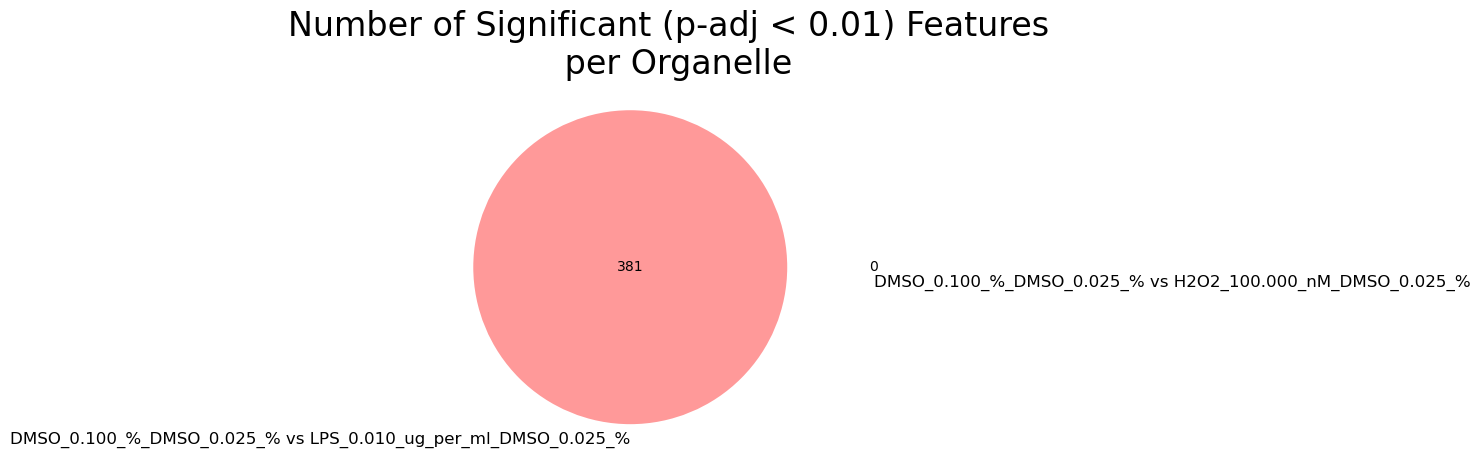

In [10]:
venn2(
    [set(tukey_df_sig_trt_1v3["features"]), set(tukey_df_sig_trt_2v3["features"])],
    set_labels=(f"{treatment1} vs {treatment2}", f"{treatment1} vs {treatment3}"),
)
plt.title("Number of Significant (p-adj < 0.01) Features \n per Organelle", size=24)
save_path = pathlib.Path(
    f"./Figures/anova_of_features/{treatment1}_vs_{treatment2}_vs_{treatment3}"
)
save_path.mkdir(parents=True, exist_ok=True)
plt.subplots_adjust(left=0.15)
plt.savefig(
    f"{save_path}/{treatment1}_vs_{treatment2}_number_sig_overlaping_features_per_organelle.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

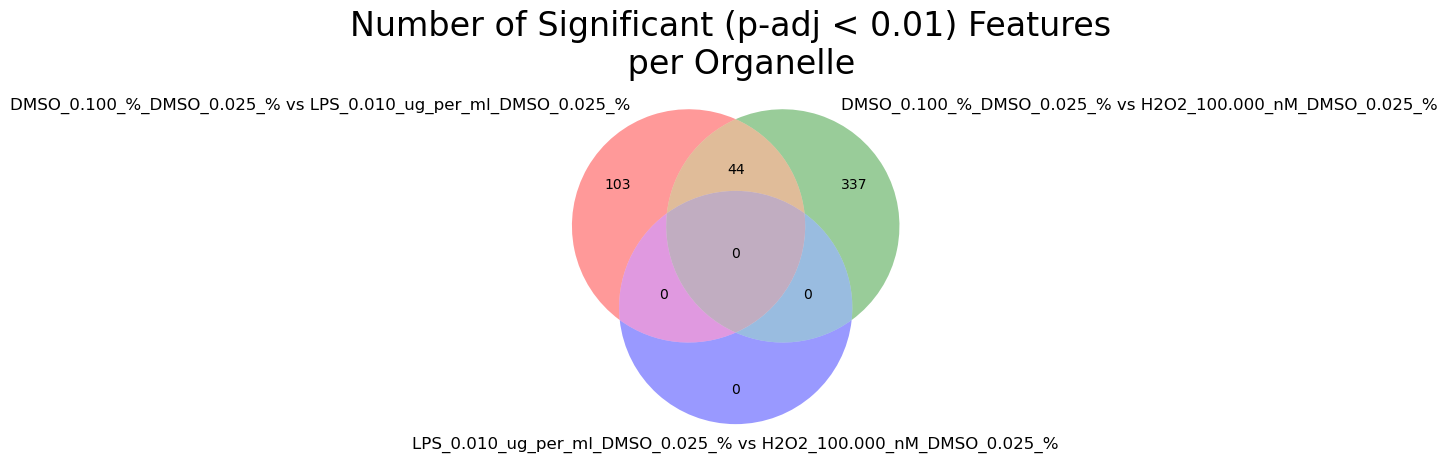

In [11]:
# create a venn diagram of the features that are significant in all conditions

venn3_unweighted(
    [
        set(tukey_df_sig_trt_1v2["features"]),
        set(tukey_df_sig_trt_1v3["features"]),
        set(tukey_df_sig_trt_2v3["features"]),
    ],
    set_labels=(
        f"{treatment1} vs {treatment2}",
        f"{treatment1} vs {treatment3}",
        f"{treatment2} vs {treatment3}",
    ),
)
plt.title("Number of Significant (p-adj < 0.01) Features \n per Organelle", size=24)
save_path = pathlib.Path(
    f"./Figures/anova_of_features/{treatment1}_vs_{treatment2}_vs_{treatment3}"
)
plt.tight_layout()
save_path.mkdir(parents=True, exist_ok=True)
plt.savefig(
    f"{save_path}/{treatment1}_vs_{treatment2}_{treatment3}_number_sig_overlaping_features_per_organelle.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [12]:
# get the features that are only in the treatment1 vs treatment2 condition and not in the other two conditions
tukey_df_sig_trt_1v2_unique = tukey_df_sig_trt_1v2[
    ~tukey_df_sig_trt_1v2["features"].isin(tukey_df_sig_trt_1v3["features"])
]
tukey_df_sig_trt_1v2_unique = tukey_df_sig_trt_1v2_unique[
    ~tukey_df_sig_trt_1v2_unique["features"].isin(tukey_df_sig_trt_2v3["features"])
]
# get the features that are only in the treatment1 vs treatmen3 condition and not in the other two conditions
tukey_df_sig_trt_1v3_unique = tukey_df_sig_trt_1v3[
    ~tukey_df_sig_trt_1v3["features"].isin(tukey_df_sig_trt_1v2["features"])
]
tukey_df_sig_trt_1v3_unique = tukey_df_sig_trt_1v3_unique[
    ~tukey_df_sig_trt_1v3_unique["features"].isin(tukey_df_sig_trt_2v3["features"])
]
# get the features that are only in the treatment2 vs treatment3 condition and not in the other two conditions
tukey_df_sig_trt_2v3_unique = tukey_df_sig_trt_2v3[
    ~tukey_df_sig_trt_2v3["features"].isin(tukey_df_sig_trt_1v2["features"])
]
tukey_df_sig_trt_2v3_unique = tukey_df_sig_trt_2v3_unique[
    ~tukey_df_sig_trt_2v3_unique["features"].isin(
        tukey_df_sig_trt_1v3_unique["features"]
    )
]
# print the number of features that are only in each condition
print(
    len(tukey_df_sig_trt_1v2_unique),
    len(tukey_df_sig_trt_1v3_unique),
    len(tukey_df_sig_trt_2v3_unique),
)

103 337 0


## Get organelle names

In [13]:
# split each feature by "_" and get the organelle name
tukey_df_sig_trt_1v2_unique["organelle"] = tukey_df_sig_trt_1v2_unique[
    "features"
].str.split("_", expand=True)[3]
tukey_df_sig_trt_1v2_unique["organelle"].unique()

array(['2', '3', '7', '8', 'CorrPM', 'CorrDNA', 'CorrGasdermin',
       'CorrMito', 'CorrER', '6', 'Adjacent'], dtype=object)

In [14]:
org_replace_dict = {
    "CorrGasdermin": "GasderminD",
    "CorrER": "ER",
    "CorrMito": "Mito",
    "CorrDNA": "DNA",
    "CorrPM": "PM",
}
# set a value for all other strings that represent "organelle", which come from either AreaShape or Neighbors module
default_value = "Other"

# replace values to represent organelle or other
tukey_df_sig_trt_1v2_unique["organelle"] = tukey_df_sig_trt_1v2_unique[
    "organelle"
].apply(lambda x: org_replace_dict.get(x, default_value))

#### Plot number of significant features by organelle

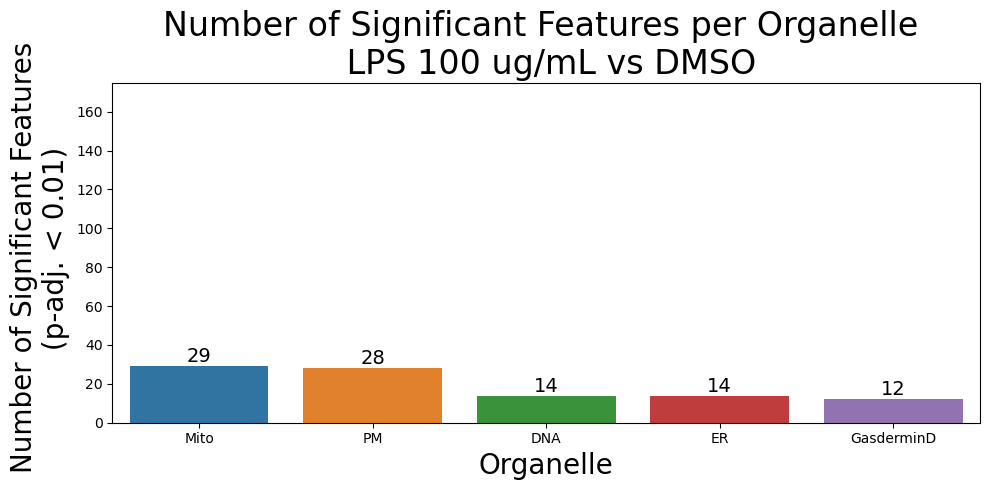

In [15]:
# drop the other organelle
tukey_df_sig_trt_1v2_unique = tukey_df_sig_trt_1v2_unique[
    tukey_df_sig_trt_1v2_unique["organelle"] != "Other"
]
# seaborn plot of each organelle and the counts of features that are significant
# set the order of the organelles
organelle_order = ["Mito", "PM", "DNA", "ER", "GasderminD"]
plt.figure(figsize=(10, 5))
sns.countplot(x="organelle", data=tukey_df_sig_trt_1v2_unique, order=organelle_order)
plt.title(
    f"Number of Significant Features per Organelle \n LPS 100 ug/mL vs DMSO", size=24
)
# add bar labels
for p in plt.gca().patches:
    plt.gca().text(
        p.get_x() + p.get_width() / 2,
        p.get_height(),
        "%d" % int(p.get_height()),
        fontsize=14,
        color="black",
        ha="center",
        va="bottom",
    )
plt.xlabel("Organelle", size=20)
plt.ylabel("Number of Significant Features \n (p-adj. < 0.01)", size=20)
plt.ylim(0, 175)
save_path = pathlib.Path(
    f"./Figures/anova_of_features/{treatment1}_vs_{treatment2}_vs_{treatment3}"
)
save_path.mkdir(parents=True, exist_ok=True)
plt.savefig(
    f"{save_path}/{treatment1}_vs_{treatment2}_number_sig_features_per_organelle.png",
    dpi=300,
)
plt.show()